# 🌳🌳🌳 Решающие деревья, случайный лес

✅ Реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки.
- При решении задачи регрессии используйте дисперсию подвыборки
- При решении задачи классификации используйте критерий Джини

Функцию`find_best_split` протестируйте на датасете `Boston` из `sklearn`

При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое.

In [1]:
!pip install "scikit-learn<1.2" #после этой строчки перезапустите ядро ноутбука

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 3.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.21.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [2]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [5]:
# Функция для вычисления критерия Джини

def gini_impurity(targets: np.ndarray) -> float:
    _, counts = np.unique(targets, return_counts=True)
    p = counts / len(targets)
    return 1 - np.sum(p**2)

In [6]:
def variance(targets: np.ndarray) -> float:
    return np.var(targets)

In [7]:
def find_best_split(feature_vector: Union[np.ndarray, pd.DataFrame], target_vector: Union[np.ndarray, pd.Series], task: str = "classification", feature_type: str = "real") -> Tuple[np.ndarray, np.ndarray, float, float]:

    if len(feature_vector) != len(target_vector):
        raise ValueError("Feature and target vectors must have the same length.")

    # Сортируем данные по признаку
    sorted_idx = np.argsort(feature_vector) # возвращает индексы, которые отсортировали бы массив feature_vector по возрастанию
    feature_vector = feature_vector[sorted_idx]
    target_vector = target_vector[sorted_idx]

    if feature_type == "real":
        thresholds = (feature_vector[1:] + feature_vector[:-1]) / 2 # Для вещественных пороги - средние значения между соседними элементами
    else:
        thresholds = np.unique(feature_vector) # Для категориальных признаков пороги — это уникальные значения признака

    best_criterion_value = float('inf') if task == 'regression' else -float('inf') # либо +бесконечность, либо -бесконечность
    best_threshold = None
    criterion_values = []

    for threshold in thresholds:

        if feature_type == "real":
            left_mask = feature_vector <= threshold
            right_mask = feature_vector > threshold
        else:
            left_mask = feature_vector == threshold
            right_mask = feature_vector != threshold

        left_targets, right_targets = target_vector[left_mask], target_vector[right_mask]

        if len(left_targets) == 0 or len(right_targets) == 0:
            continue  # Пропускаем пустые подмножества

        if task == 'regression':

            left_var = variance(left_targets)
            right_var = variance(right_targets)

            weighted_variance = (len(left_targets) / len(target_vector)) * left_var + (len(right_targets) / len(target_vector)) * right_var
            criterion_values.append(weighted_variance)

            if weighted_variance < best_criterion_value:
                best_criterion_value = weighted_variance
                best_threshold = threshold

        elif task == 'classification':

            left_gini = gini_impurity(left_targets)
            right_gini = gini_impurity(right_targets)

            weighted_gini = -(len(left_targets) / len(target_vector)) * left_gini - (len(right_targets) / len(target_vector)) * right_gini
            criterion_values.append(weighted_gini)

            if weighted_gini > best_criterion_value:
                best_criterion_value = weighted_gini
                best_threshold = threshold

    return np.array(thresholds), np.array(criterion_values), best_threshold, best_criterion_value

In [8]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(),
    y,
    task="regression",
    feature_type="real"
)

**Посмотрим на самый оптимальный порог**

In [9]:
threshold_best

6.68632

**Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.**

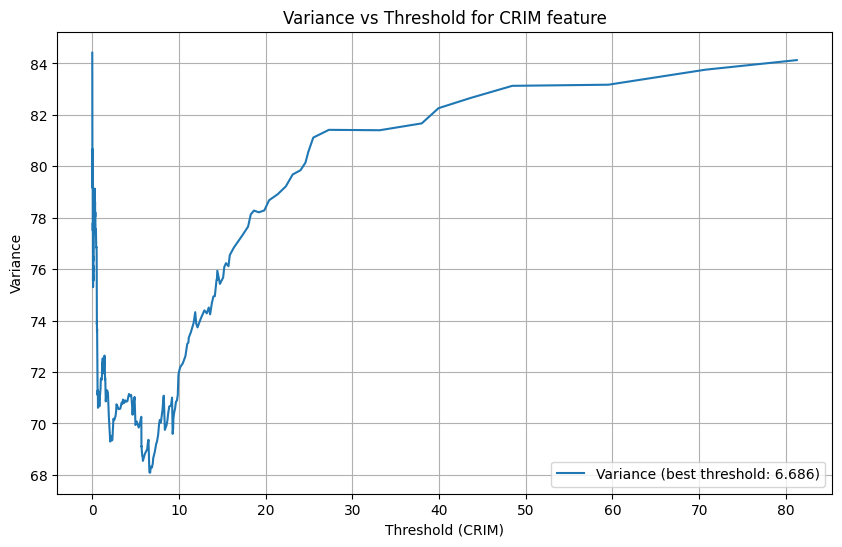

(6.68632, 68.08324641384722)

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, variances, label=f"Variance (best threshold: {threshold_best:.3f})")
plt.xlabel('Threshold (CRIM)')
plt.ylabel('Variance')
plt.title('Variance vs Threshold for CRIM feature')
plt.legend()
plt.grid(True)
plt.show()

threshold_best, variance_best